In [21]:
#The datas are not uploaded to the repository, extract them to your base folder
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\Users\PC\Documents\GitHub\WindPower_Estimation'
train1_dataset = pd.read_csv (r''+dataPath+'\Case1\Dataset_Train_1.csv', header=0, delim_whitespace=False)
train2_dataset = pd.read_csv (r''+dataPath+'\Case2\Dataset_Train_2.csv', header=0, delim_whitespace=False)
train3_dataset = pd.read_csv (r''+dataPath+'\Case3\Dataset_Train_3.csv', header=0, delim_whitespace=False)
test1_dataset = pd.read_csv (r''+dataPath+'\Case1\Dataset_Test_1.csv', header=0, delim_whitespace=False)
test2_dataset = pd.read_csv (r''+dataPath+'\Case2\Dataset_Test_2.csv', header=0, delim_whitespace=False)
test3_dataset = pd.read_csv (r''+dataPath+'\Case3\Dataset_Test_3.csv', header=0, delim_whitespace=False)



# ######################
# batch_size = 16
# #deleting the the extra data that doesnt fit the batch size
# modulus = len(train1_dataset) %batch_size
# train1_dataset = train1_dataset.iloc[ modulus: , :]
# train1_dataset = train1_dataset.reset_index()
# #print( new_train_temp )



# test1_dataset = test1_dataset.drop(axis=1, columns= ['Date_Time', 'Direction_10m', 'Speed_10m', 'Temperature_10m', 'Pressure_seaLevel', 'Air_Density_10m', 'Temperature_50m', 'Air_Density_50m', 'Direction_100m', 'Speed_100m', 'Temperature_100m','Air_Density_100m', 'Direction_150m', 'Speed_150m', 'Temperature_150m', 'Air_Density_150m'] )     
# test1_dataset = test1_dataset.to_numpy()
# test1_dataset = torch.tensor( test1_dataset )           

# train1_dataset = train1_dataset.drop(axis=1, columns= ['Date_Time', 'Direction_10m', 'Speed_10m', 'Temperature_10m', 'Pressure_seaLevel', 'Air_Density_10m', 'Temperature_50m', 'Air_Density_50m', 'Direction_100m', 'Speed_100m', 'Temperature_100m','Air_Density_100m', 'Direction_150m', 'Speed_150m', 'Temperature_150m', 'Air_Density_150m'] )     
# train1_dataset = train1_dataset.to_numpy()
# train1_dataset = torch.tensor( train1_dataset )           
                                                     
# temp = test1_dataset['Date_Time'].astype('datetime64',copy=False)
# temp = torch.tensor(temp.values)
# test1_dataset = torch.tensor(test1_dataset.values)
# print( temp )


#torch_tensor = torch.from_numpy( test1_dataset.values.astype(np.float32) )
print( test1_dataset ) 


                 Date_Time  Direction_10m  Speed_10m  Temperature_10m  \
0      2020-05-18 13:15:00       0.233983   0.523846         0.708869   
1      2020-05-18 13:30:00       0.236769   0.527692         0.706422   
2      2020-05-18 13:45:00       0.242340   0.530000         0.703976   
3      2020-05-18 14:00:00       0.247911   0.530769         0.701835   
4      2020-05-18 14:15:00       0.250696   0.530000         0.699847   
...                    ...            ...        ...              ...   
29436  2021-01-25 18:45:00       0.370474   0.176154         0.463456   
29437  2021-01-25 19:00:00       0.370474   0.176154         0.463456   
29438  2021-01-25 19:15:00       0.370474   0.176154         0.463456   
29439  2021-01-25 19:30:00       0.370474   0.176154         0.463456   
29440  2021-01-25 19:45:00       0.370474   0.176154         0.463456   

       Pressure_seaLevel  Air_Density_10m  Direction_50m  Speed_50m  \
0               0.512525         0.250737       0.23

In [22]:
# FFNN 

In [23]:
import torch
#print(torch.__version__)
#print(torch.version.cuda)
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F

# Load functions
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [24]:
# Definition of class for batch generation
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataSet(Dataset):
  """
  This is a custom dataset class. It can get more complex than this, but simplified so you can understand what's happening here without
  getting bogged down by the preprocessing
  """
  def __init__(self, X, Y, Z):
    self.X = X
    self.Y = Y
    self.Z = Z
    if len(self.X) != len(self.Y) :
      raise Exception("The length of X does not match the length of Y")
    if len(self.X) != len(self.Z) :
      raise Exception("The length of X does not match the length of Z")
    if len(self.Z) != len(self.Y) :
      raise Exception("The length of Z does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index]
    _y = self.Y[index]
    _z = self.Z[index]

    return _x , _y , _z 

In [25]:
# Definition of the FFNN architecture
class Net(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=10, learn_bias=False ):
        super(Net, self).__init__()
        
        self.ffn1 = nn.Linear(in_features =in_channels,
                              out_features =mid_channels,
                              bias = learn_bias)
        

        self.batchnorm_1 = nn.BatchNorm1d(mid_channels)
        self.dropout_1 = nn.Dropout(p=0.50, inplace=False)
        
        self.ffn2 = nn.Linear(in_features =mid_channels,
                              out_features =out_channels,
                              bias = learn_bias)
        
    def forward(self, x):
        
#         print( x.shape)
#         x = np.concatenate(x, axis=1)
#         x=self.ffn1(x)
#         x=self.batchnorm_1( x)
#         x=F.relu(x)
#         x=self.ffn2(x)
#         x=F.relu(x )      
        
        x=self.ffn1( x )
        x=self.ffn2( x )
        return x  



In [26]:
# # Putting to CUDA the dataset
# use_cuda = torch.cuda.is_available()
# print("Running GPU.") if use_cuda else print("No GPU available.")

# def get_variable(x):
#     """ Converts tensors to cuda, if available. """
#     if use_cuda:
#         return x.cuda()
#     return x

# def get_numpy(x):
#     """ Get numpy array for both cuda and not. """
#     if use_cuda:
#         return x.cpu().data.numpy()
#     return x.data.numpy()




In [33]:
# Network creation and paramter modification

batch_size = 96
in_channels_setting = batch_size
out_channels_setting = batch_size
mid_channels_setting = 10


net = Net(in_channels_setting, out_channels_setting, mid_channels_setting)
# if use_cuda:
#     net.cuda()
#     train1_dataset.cuda
#     test1_dataset.cuda
#     print('run on cuda')
# print(net)

# We can play with 0.0005 too
LEARNING_RATE = 0.001
criterion =  nn.MSELoss()       
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


In [34]:
### Training

In [42]:
###### setting hyperparameters and gettings epoch sizes
num_epochs = 20
num_samples_train = len( train1_dataset )
num_batches_train = (num_samples_train // batch_size ) 
num_samples_valid = len( test1_dataset )
num_batches_valid = (num_samples_valid // batch_size ) 

# setting up lists for handling loss
losses_train_train = []
Losses_train_valid = []
Losses_test = []
#get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    train_loader = iter(DataLoader(TimeSeriesDataSet(train1_dataset['Direction_50m'], train1_dataset['Speed_50m'], train1_dataset['Speed_50m'] ), batch_size= batch_size, shuffle=False))

    train_train_cur_loss = 0
    net.train()
    print( f'new epoch, number{epoch}')
    for i in range(num_batches_train-10):
        #print( f'{i} run')
        optimizer.zero_grad()
        x, y, z = train_loader.next()
#         print( y.shape)
        output = net( y.float() )
        
        
        # compute gradients given loss
        # get the target ==> Z
        batch_loss = criterion(output.float(), z.float())
        batch_loss.backward()
        optimizer.step()

        
        train_train_cur_loss += batch_loss   
    losses_train_train.append(train_train_cur_loss / batch_size)
    
    net.eval()
    ### Evaluate training
    train_loader = iter(DataLoader(TimeSeriesDataSet(train1_dataset['Direction_50m'], train1_dataset['Speed_50m'], train1_dataset['Speed_50m'] ), batch_size= batch_size, shuffle=False))
    train_val_cur_loss = 0
    for i in range(num_batches_train):
        x, y, z = train_loader.next()
        output = net( y.float() )
        
        batch_loss = criterion(output.float(), z.float())
#         print(batch_loss)
        train_val_cur_loss += batch_loss.detach().numpy()
    Losses_train_valid.append(train_val_cur_loss / batch_size)
    
    ### Evaluate validation
    test_loader = iter(DataLoader(TimeSeriesDataSet(test1_dataset['Direction_50m'], test1_dataset['Speed_50m'], test1_dataset['Speed_50m'] ), batch_size= batch_size, shuffle=False))
    test_cur_loss = 0
    for i in range(num_batches_valid):
        x, y, z = test_loader.next()
        output = net( y.float() )
        
        batch_loss = criterion(output.float(), z.float())
        
        test_cur_loss += batch_loss.detach().numpy()
    Losses_test.append(test_cur_loss / batch_size)
    
    


new epoch, number0
new epoch, number1
new epoch, number2
new epoch, number3
new epoch, number4
new epoch, number5
new epoch, number6
new epoch, number7
new epoch, number8
new epoch, number9
new epoch, number10
new epoch, number11
new epoch, number12
new epoch, number13
new epoch, number14
new epoch, number15
new epoch, number16
new epoch, number17
new epoch, number18
new epoch, number19


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

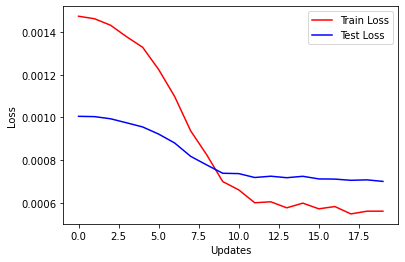

In [43]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot( Losses_train_valid, 'r', Losses_test, 'b') #, epoch, Losses_test, 'b')
plt.legend(['Train Loss','Test Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

In [46]:
    net.eval()
### Evaluate validation
    test_loader = iter(DataLoader(TimeSeriesDataSet(test1_dataset['Direction_50m'], test1_dataset['Speed_50m'], test1_dataset['Speed_50m'] ), batch_size= batch_size, shuffle=False))
    test_cur_loss = 0

    x, y, z = test_loader.next()
    output = net( y.float() )

    batch_loss = criterion(output.float(), z.float())

    test_cur_loss += batch_loss.detach().numpy()
    Losses_test.append(test_cur_loss / batch_size)

In [47]:
print(x)
print(y)
print(z)
print(output)
print(z-output)

tensor([0.2312, 0.2368, 0.2423, 0.2479, 0.2507, 0.2563, 0.2618, 0.2674, 0.2730,
        0.2813, 0.2869, 0.2925, 0.2981, 0.3036, 0.3092, 0.3120, 0.3120, 0.3120,
        0.3120, 0.3120, 0.3092, 0.3064, 0.3036, 0.3008, 0.2981, 0.2925, 0.2897,
        0.2869, 0.2869, 0.2897, 0.2925, 0.2953, 0.2981, 0.3036, 0.3064, 0.3120,
        0.3175, 0.3203, 0.3231, 0.3259, 0.3231, 0.3203, 0.3148, 0.3092, 0.3036,
        0.2953, 0.2897, 0.2813, 0.2758, 0.2702, 0.2674, 0.2674, 0.2674, 0.2674,
        0.2702, 0.2702, 0.2730, 0.2758, 0.2786, 0.2786, 0.2813, 0.2813, 0.2813,
        0.2841, 0.2841, 0.2841, 0.2841, 0.2813, 0.2813, 0.2813, 0.2813, 0.2813,
        0.2813, 0.2813, 0.2813, 0.2841, 0.2841, 0.2841, 0.2869, 0.2869, 0.2897,
        0.2897, 0.2925, 0.2925, 0.2953, 0.2953, 0.2953, 0.2981, 0.2953, 0.2953,
        0.2953, 0.2953, 0.2981, 0.2981, 0.2981, 0.2981], dtype=torch.float64)
tensor([0.5473, 0.5509, 0.5527, 0.5536, 0.5527, 0.5491, 0.5438, 0.5366, 0.5277,
        0.5179, 0.5062, 0.4946, 0.4830, 0.